# CAVI in a Simple Gaussian Model

To get some intuition for coordinate ascent variational inference (CAVI), let's go back to our favorite example. In lecture 1, we introduce the normal-inverse-chi-squared (NIX) distribution as a conjugate prior for the Gaussian with unknown mean and variance. For that simple model, we could compute the exact posterior in closed form (the posterior is an NIX distribution too!). Let's pretend we don't know the true posterior and instead perform approximate inference with CAVI.
 
**Notation:** Let,
- $x_n \in \mathbb{R}$ denote the $n$-th data point,
- $\mu \in \mathbb{R}$ denote the unknown mean of the distribution, and
- $\sigma^2 \in \mathbb{R}_+$ denote the unknown variance of the distribution.
- $\mu_0, \kappa_0, \nu_0, \sigma_0^2$ denote the hyperparameters of a NIX prior on $(\mu, \sigma^2)$.

**Model:**

$$
\begin{align*}
\sigma^2 &\sim \chi^{-2}(\nu_0, \sigma_0^2) \\
\mu \mid \sigma^2 &\sim \mathcal{N}(\mu_0, \kappa_0^{-1} \sigma^2) \\
x_n \mid \mu, \sigma^2 &\sim \mathcal{N}(\mu, \sigma^2)  \quad  \text{for } n =1, \ldots, N
\end{align*}
$$

In [1]:
import torch
from torch.distributions import Normal, Gamma, StudentT, TransformedDistribution
from torch.distributions.transforms import PowerTransform
torch.manual_seed(305)

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_context("notebook")

In [2]:
class ScaledInvChiSq(TransformedDistribution):
    """
    Implementation of the scaled inverse \chi^2 distribution defined in class.
    We will implement it as a transformation of a gamma distribution.
    """
    def __init__(self, dof, scale):
        base = Gamma(dof / 2, dof * scale / 2)
        transforms = [PowerTransform(-1)]
        TransformedDistribution.__init__(self, base, transforms)
        self.dof = dof
        self.scale = scale

In [3]:
# Set NIX hypers
mu0 = torch.tensor(0.)
kappa0 = torch.tensor(1.0)
nu0 = torch.tensor(2.0)
sigmasq0 = torch.tensor(2.0)

# Sample from the model
N = 20
sigmasq = ScaledInvChiSq(nu0, sigmasq0).sample()
mu = Normal(mu0, torch.sqrt(sigmasq / kappa0)).sample()
X = Normal(mu, torch.sqrt(sigmasq)).sample(sample_shape=(N,))
print("mean X: ", X.mean())
print("var X: ", X.var())

# Compute the posterior
nu_N = nu0 + N
kappa_N = kappa0 + N
mu_N = 1/kappa_N * (kappa0 * mu0 + X.sum())
sigmasq_N = 1/nu_N * (nu0 * sigmasq0 + kappa0 * mu0**2 + torch.sum(X**2) - kappa_N * mu_N**2)
print("E[mu | X]:      ", mu_N)
print("E[sigmasq | X]: ", sigmasq_N * (nu_N / (nu_N + 2)))

mean X:  tensor(-0.9374)
var X:  tensor(2.3735)
E[mu | X]:       tensor(-0.8927)
E[sigmasq | X]:  tensor(2.0805)


In [4]:
# Evaluate the density on a grid
def plot_nix(mu_N, kappa_N, nu_N, sigmasq_N, q_mu=None, q_sigmasq=None,
             mu_min=-2, mu_max=0, sigmasq_min=1, sigmasq_max=4, title=""):
    
    # Make a grid of mu and sigmasq values
    mus = torch.linspace(mu_min, mu_max, 50)
    sigmasqs = torch.linspace(sigmasq_min, sigmasq_max, 50)
    mu_grid, sigmasq_grid = torch.meshgrid(mus, sigmasqs)
    
    # Compute the true log probability
    true_log_prob = ScaledInvChiSq(nu_N, sigmasq_N).log_prob(sigmasq_grid)
    true_log_prob += Normal(mu_N, torch.sqrt(sigmasq_grid / kappa_N)).log_prob(mu_grid)
    
    # Compute the true marginals
    sigmasq_marginal = ScaledInvChiSq(nu_N, sigmasq_N)
    mu_marginal = StudentT(nu_N, mu_N, torch.sqrt(sigmasq_N / kappa_N))

    # Start with a square Figure.
    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                        left=0.1, right=0.9, bottom=0.1, top=0.9,
                        wspace=0.1, hspace=0.1)
    
    ax_j = fig.add_subplot(gs[1, 0])
    ax_j.contourf(mu_grid, sigmasq_grid, torch.exp(true_log_prob), 10)
    ax_j.set_xlim(mu_min, mu_max)
    ax_j.set_ylim(sigmasq_min, sigmasq_max)
    ax_j.set_xlabel("$\mu$")
    ax_j.set_ylabel("$\sigma^2$")
    # ax_j.set_title("joint distribution")
    
    ax_mu = fig.add_subplot(gs[0,0], sharex=ax_j)
    ax_mu.plot(mus, torch.exp(mu_marginal.log_prob(mus)))
    # ax_mu.set_title(r"$\mu$ marginal")
    plt.setp(ax_mu.get_xticklabels(), visible=False)
    
    ax_sig = fig.add_subplot(gs[1,1], sharey=ax_j)
    ax_sig.plot(torch.exp(sigmasq_marginal.log_prob(sigmasqs)), sigmasqs)
    # ax_sig.set_title(r"$\sigma^2$ marginal")
    plt.setp(ax_sig.get_yticklabels(), visible=False)
    
    # If variational posterior is given, plot its joint and marginals
    if q_mu is not None and q_sigmasq is not None:
        var_log_prob = q_sigmasq.log_prob(sigmasq_grid)
        var_log_prob += q_mu.log_prob(mu_grid)
        ax_j.contour(mu_grid, sigmasq_grid, torch.exp(var_log_prob), 
                     10, colors='r', linewidths=1)

        ax_mu.plot(mus, torch.exp(q_mu.log_prob(mus)), color='r', ls='--')
        ax_sig.plot(torch.exp(q_sigmasq.log_prob(sigmasqs)), sigmasqs, color='r', ls='--')

    plt.suptitle(title)
    return fig
    

/Users/scott/miniconda3/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


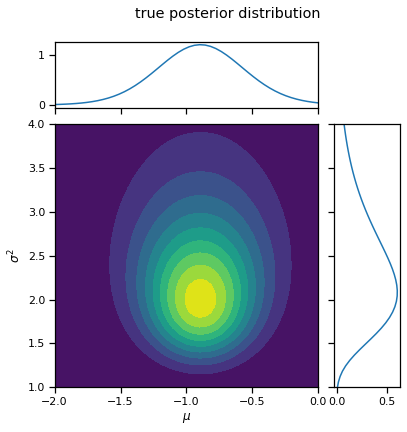

In [5]:
_ = plot_nix(mu_N, kappa_N, nu_N, sigmasq_N, title="true posterior distribution")

## Approximate the posterior with CAVI

The true posterior is *not* independent: 

$$
\begin{align*}
p(\mu, \sigma^2 \mid X) 
&= \mathrm{NIX}(\mu, \sigma^2 \mid \mu_N, \kappa_N, \nu_N, \sigma_N^2) \\
&= \mathcal{N}(\mu \mid \mu_N, \kappa_N^{-1} \sigma^2) \, \chi^{-2}(\sigma^2 \mid \nu_N, \sigma_N^2) \\
&\neq p(\mu \mid X) \, p(\sigma^2 \mid X)
\end{align*}
$$

As we emphasized in lecture 1, the true posterior factors into a scaled inverse chi-squared distribution on $\sigma^2$ time a normal distribution on $\mu$ whose _variance depends on_ $\sigma^2$.

Suppose, however, that we approximated the posterior with variational inference, assuming a mean field posterior of the form,

$$
\begin{align*}
p(\mu, \sigma^2 \mid X) 
&\approx q(\mu, \sigma^2) \triangleq q(\mu) \, q(\sigma^2)
\end{align*}
$$

For conjugate, exponential family models like this, we don't need to assume a functional form for the factors. As we'll see, the optimal form of the posterior factors will be the same family as the prior.

<!-- Moreover, assume the following functional forms for the posterior factors (these will turn out to be optimal anyway),

$$
\begin{align*}
q(\mu) &= \mathcal{N}(\mu \mid \widetilde{\mu}, \widetilde{v}) \\
q(\sigma^2) &= \chi^{-2}(\sigma^2 \mid \widetilde{\nu}, \widetilde{\sigma}^2) \\
\end{align*}
$$

with **variational parameters** $\lambda = (\widetilde{\mu}, \widetilde{v}, \widetilde{\nu}, \widetilde{\sigma}^2)$. Our goal is to find parameters $\lambda$  -->

Out goal is to find a posterior approximation that minimizes the KL divergence, $\mathrm{KL}(q(\mu, \sigma^2) \, \|\, p(\mu, \sigma^2 \mid X))$, or, equivalently, maximize the **evidence lower bound (ELBO)**:

$$
\begin{align*}
\mathcal{L}[q] &=
\mathbb{E}_{q(\mu, \sigma^2)}\left[ \log p(X, \mu, \sigma^2) - \log q(\mu, \sigma^2) \right].
\end{align*}
$$

We will do so by coordinate ascent &mdash; iteratively optimizing with respect to the parameters for $q(\mu)$ then for $q(\sigma^2)$, holding the other fixed. This is called **coordinate ascent variational inference (CAVI)**.

### Optimizing with respect to $q(\mu)$

First, let's maximize the ELBO with respect to $q(\mu)$. The trick is to notice that the problem simplifies due to the mean field posterior assumption and the conjugacy of the model. 

Expanding the ELBO and dropping terms that don't depend on $q(\mu)$,

$$
\begin{align*}
\mathcal{L}[q]
&=\mathbb{E}_{q(\mu)} \mathbb{E}_{q(\sigma^2)} \left[\sum_{n=1}^N \log p(x_n \mid \mu, \sigma^2) + \log p(\mu \mid \sigma^2) + \log p(\sigma^2) - \log q(\mu) -\log q(\sigma^2) \right] \\
&= \mathbb{E}_{q(\mu)} \left[ \mathbb{E}_{q(\sigma^2)} \left[ \sum_{n=1}^N  \log p(x_n \mid \mu, \sigma^2) + \log p(\mu \mid \sigma^2) - \log q(\mu) \right]\right] + 
\underbrace{\mathbb{E}_{q(\sigma^2)}\left[ \log p(\sigma^2) - \log q(\sigma^2) \right]}_{\mathrm{KL}(q(\sigma^2) \, \| \, p(\sigma^2))}.
\end{align*}
$$

We can drop the final KL term since it's constant wrt $q(mu)$. Now let's expand the functional form of the model,

$$
\begin{align*}
\mathcal{L}[q]
&= \mathbb{E}_{q(\mu)} \left[ \mathbb{E}_{q(\sigma^2)} \left[ \sum_{n=1}^N  \log \mathcal{N}(x_n \mid \mu, \sigma^2) + \log \mathcal{N}(\mu \mid \mu_0, \kappa_0^{-1} \sigma^2) - \log q(\mu) \right]\right] + c\\
&= \mathbb{E}_{q(\mu)} \left[ \mathbb{E}_{q(\sigma^2)} \left[ \sum_{n=1}^N  -\frac{1}{2\sigma^2} (x_n - \mu)^2 + \frac{\kappa_0}{2\sigma^2} (\mu - \mu_0)^2 - \log q(\mu) \right]\right] + c\\
&= \mathbb{E}_{q(\mu)} \left[ -\frac{1}{2} \widetilde{J} \mu^2 + \widetilde{h} \mu - \log q(\mu) \right] + c\\
\end{align*}
$$

where 

$$
\begin{align*}
\widetilde{J} &= (N + \kappa_0) \, \mathbb{E}_{q(\sigma^2)}[\sigma^{-2}] \\
\widetilde{h} &= \left(\sum_{n=1}^N x_n + \kappa_0 \mu_0\right) \mathbb{E}_{q(\sigma^2)}[\sigma^{-2}] 
\end{align*}
$$

We recognize the first terms inside the expectation as the log probability of a Gaussian distribution, up to a constant,

$$
\begin{align*}
\widetilde{p}(\mu)
&= \mathcal{N}(\mu \mid \widetilde{\mu}, \widetilde{v}) \\
\widetilde{\mu} &= \widetilde{J}^{-1} \widetilde{h} \\
\widetilde{v} &= \widetilde{J}^{-1}
\end{align*}
$$

Moreover, we can rewrite the ELBO as a negative KL divergence,

$$
\begin{align*}
\mathcal{L}[q]
&= \mathbb{E}_{q(\mu)} \left[ \log \widetilde{p}(\mu) - \log q(\mu) \right] + c  
= -\mathrm{KL}(q(\mu) \, \| \, \widetilde{p}(\mu)) + c
\end{align*}
$$

Thus, maximizing the ELBO wrt $q(\mu)$ is the same as minimizing this KL divergence. When is the KL minimized? When the two distributions are equal! Thus, the optimal coordinate update for $q(\mu)$ is,

$$
q^\star(\mu) = \mathcal{N}(\mu \mid \widetilde{\mu}, \widetilde{v}) 
$$

**Note:** the parameters $J$ and $h$ depend on $q(\sigma^2)$ through the expectation, $\mathbb{E}_q[\sigma^{-2}]$. 

**Question:** does the mean of $q^\star(\mu)$ depend on $q(\sigma^2)$?

### Optimizing with respect to $q(\sigma^2)$


Now let's maximize the ELBO with respect to $q(\sigma^2)$,

$$
\begin{align*}
\mathcal{L}[q]
&=\mathbb{E}_{q(\sigma^2)} \mathbb{E}_{q(\mu)} \left[\sum_{n=1}^N \log p(x_n \mid \mu, \sigma^2) + \log p(\mu \mid \sigma^2) + \log p(\sigma^2) -\log q(\sigma^2) \right] + c \\
&=\mathbb{E}_{q(\sigma^2)} \mathbb{E}_{q(\mu)} \left[\sum_{n=1}^N \log \mathcal{N}(x_n \mid \mu, \sigma^2) + \log \mathcal{N}(\mu \mid \mu_0, \kappa_0^{-1} \sigma^2) + \log \chi^{-2}(\sigma^2 \mid \nu_0, \sigma_0^2) -\log q(\sigma^2) \right] + c \\
&= \mathbb{E}_{q(\sigma^2)} \mathbb{E}_{q(\mu)} \left[-\left(\frac{\nu_0 + N + 1}{2} + 1\right) \log \sigma^{2} -\frac{1}{2\sigma^2} \left(\sum_{n=1}^N (x_n - \mu)^2 + \kappa_0 (\mu - \mu_0)^2 + \nu_0 \sigma_0^2 \right)  -\log q(\sigma^2) \right] + c \\
&= \mathbb{E}_{q(\sigma^2)} \left[\log \widetilde{p}(\sigma^2) -\log q(\sigma^2) \right] + c \\
\end{align*}
$$

where

$$
\begin{align*}
\widetilde{p}(\sigma^2) &= \chi^{-2}(\sigma^2 \mid \widetilde{\nu}, \widetilde{\sigma}^2) \\
\widetilde{\nu} &= \nu_0 + N + 1 \\
\widetilde{\sigma}^2 &= \widetilde{\nu}^{-1} \left(\sum_{n=1}^N \mathbb{E}_{q(\mu)}[(x_n - \mu)^2] + \kappa_0 \mathbb{E}_{q(\mu)}[(\mu - \mu_0)^2] + \nu_0 \sigma_0^2 \right)
\end{align*}
$$

As before, maximizing the ELBO wrt $q(\sigma^2)$ is equivalent to minimizing a KL divergence to $\widetilde{p}(\sigma^2)$. Thus, the optimal update is,

$$
q(\sigma^2) = \chi^{-2}(\sigma^2 \mid \widetilde{\nu}, \widetilde{\sigma}^2).
$$

### Computing the necessary expectations

Now that we know the form of the variational posterior factors, we can compute the necessary expectations for each update. 

1. To update $q(\mu)$ we need $\mathbb{E}_{q(\sigma^2)}[\sigma^{-2}]$. Under a scaled inverse chi-squared distribution, $q(\sigma^2) = \chi^{-2}(\sigma^2 \mid \widetilde{\nu}, \widetilde{\sigma}^2)$, this is,
    
    $$
    \mathbb{E}_{q(\sigma^2)}[\sigma^{-2}] = \widetilde{\sigma}^2 
    $$

2. To update $q(\sigma^2)$ we need expectations of the form $\mathbb{E}_{q(\mu)}[(x - \mu)^2]$. Under a Gaussian distribution, $q(\mu) = \mathcal{N}(\mu \mid \widetilde{\mu}, \widetilde{v})$, these are,
    
    $$
    \mathbb{E}_{q(\mu)}[(x - \mu)^2] = (x-\widetilde{\mu})^2 + \widetilde{v}.
    $$

### Exercise: Derive a closed form expression for the ELBO

You can compute the ELBO in closed form too. As an exercise, try deriving an expression for it yourself.

## Let's implement it!

We've done the hard part. Now let's try to write it in code!

In [6]:
# Helper functions to compute necessary expectations
def expec_sigmasq_inv(q_sigmasq):
    """Compute E_{q(\sigma^2)}[1/\sigma^2]"""
    return 1 / q_sigmasq.scale


def expec_quadratic(x, q_mu):
    """Compute E_{q(\mu)}[(x - mu)^2]"""
    return (x - q_mu.mean)**2 + q_mu.variance

In [7]:
def _cavi_update_mu(X, q_sigmasq, mu0, kappa0):
    """CAVI update for q(\mu) holding q(\sigma^2) fixed.

    Args:
        X: data array (shape (N,))
        q_sigmasq: ScaledInvChiSq distribution
        mu0: prior mean (scalar)
        kappa0: prior precision factor (scalar)
    """
    N = len(X)
    E_sigmasq_inv = expec_sigmasq_inv(q_sigmasq)
    J_tilde = (N + kappa0) * E_sigmasq_inv
    h_tilde = (X.sum() + kappa0 * mu0) * E_sigmasq_inv
    mu_tilde = h_tilde / J_tilde
    v_tilde = 1 / J_tilde
    return Normal(mu_tilde, torch.sqrt(v_tilde))


def _cavi_update_sigmasq(X, q_mu, mu0, kappa0, nu0, sigmasq0):
    """CAVI update for q(\sigma^2) holding q(\mu) fixed

    Args:
        X: data array (shape (N,))
        q_mu: Normal distribution
        mu0: prior mean (scalar)
        kappa0: prior precision factor (scalar)
        nu0: prior degrees of freedom (scalar)
        sigmasq0: prior scale (scalar)
    """
    N = len(X)
    nu_tilde = nu0 + N + 1
    sigmasq_tilde = (expec_quadratic(X, q_mu).sum() +
                     kappa0 * expec_quadratic(mu0, q_mu) +
                     nu0 * sigmasq0) / nu_tilde
    return ScaledInvChiSq(nu_tilde, sigmasq_tilde)

In [8]:
def cavi(X, q_mu, q_sigmasq, mu0, kappa0, nu0, sigmasq0, num_steps=20):
    """Run CAVI!

    Args:
        X: data array (shape (N,))
        q_mu: initial Normal distribution
        q_sigmasq: initial ScaledInvChiSq distribution
        mu0: prior mean (scalar)
        kappa0: prior precision factor (scalar)
        nu0: prior degrees of freedom (scalar)
        sigmasq0: prior scale (scalar)
        num_iters: number of iterations to run for (int)
    """
    fig = plot_nix(mu_N, kappa_N, nu_N, sigmasq_N, q_mu=q_mu, q_sigmasq=q_sigmasq, title="step 0")
    fig.savefig("step_{:02d}.png".format(0))
    
    for step in range(num_steps):
        # Alternate between mu and sigmasq updates
        # Split them up so we can watch each coordinate update        
        if step % 2 == 0:
            q_mu = _cavi_update_mu(X, q_sigmasq, mu0, kappa0)
        else:
            q_sigmasq = _cavi_update_sigmasq(X, q_mu, mu0, kappa0, nu0, sigmasq0)
            
        fig = plot_nix(mu_N, kappa_N, nu_N, sigmasq_N, q_mu=q_mu, q_sigmasq=q_sigmasq, 
                       title="step {}".format(step+1))
        fig.savefig("step_{:02d}.png".format(step+1))
        
    return q_mu, q_sigmasq

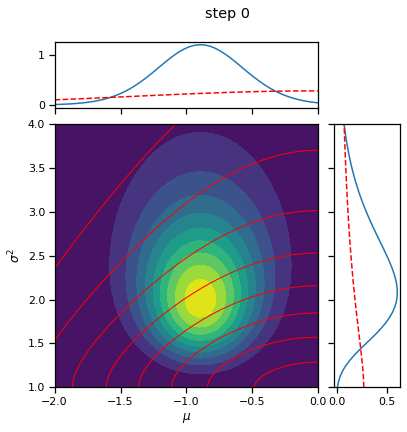

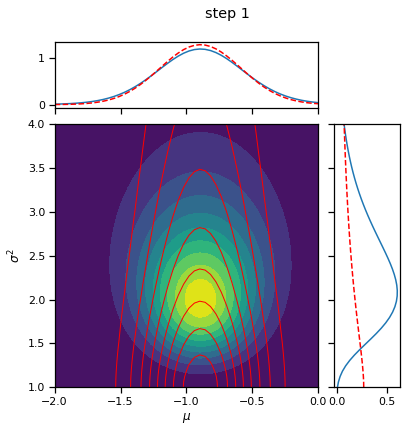

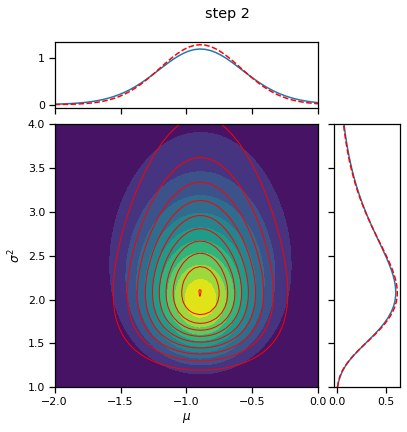

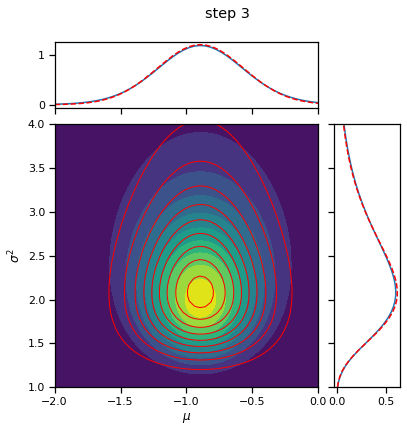

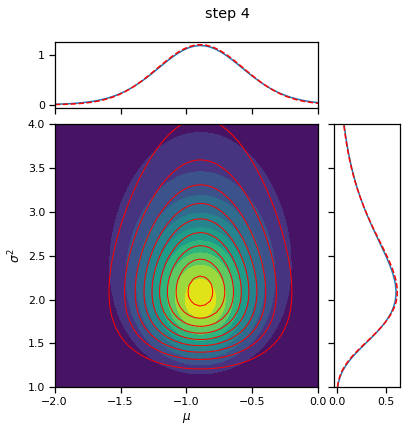

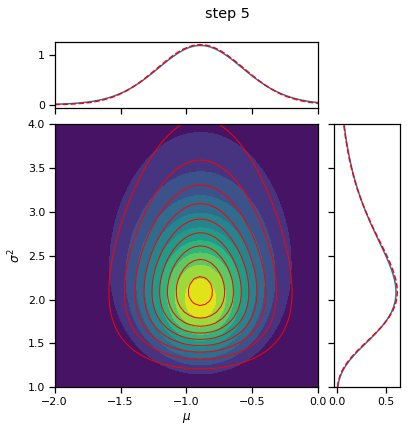

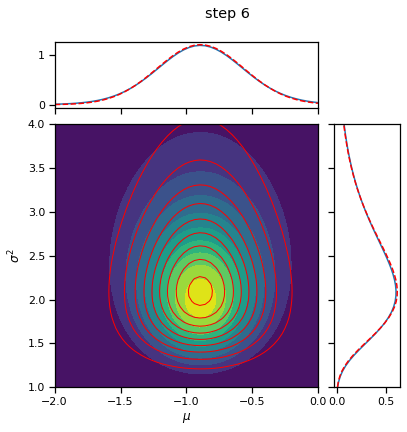

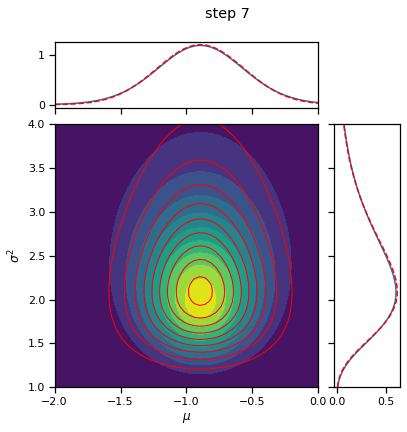

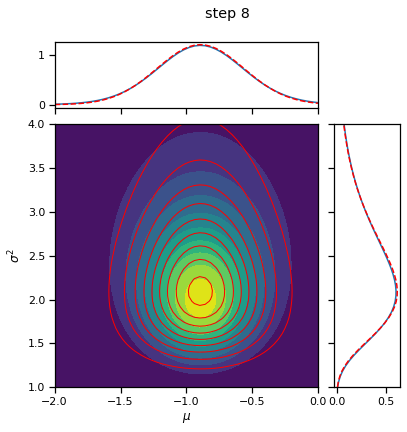

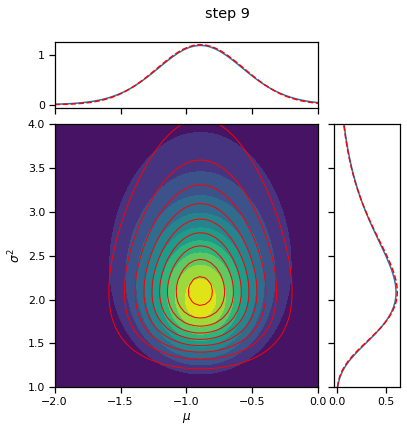

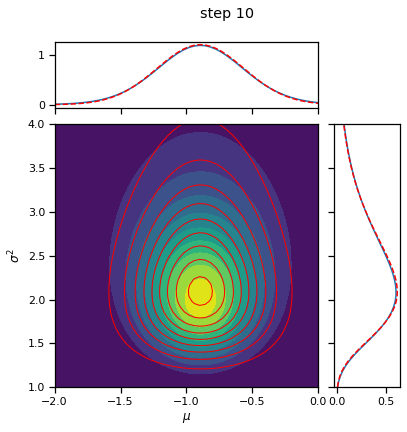

In [9]:
# Initialize the posterior factors near the prior
init_q_sigmasq = ScaledInvChiSq(nu0, sigmasq0)
init_q_mu = Normal(mu0, torch.sqrt(sigmasq0 / kappa0))

q_mu, q_sigmasq = cavi(X, init_q_mu, init_q_sigmasq, mu0, kappa0, nu0, sigmasq0, num_steps=10)

In [10]:
!convert -delay 100 -loop 0 `ls -v step_*.png` cavi_nix.gif
!rm step_*.png

<img src="cavi_nix.gif" width="750" align="center">